# ARES + Tinker Training Analysis

Visualize training metrics from `metrics.jsonl` logs. Add run directories to `RUNS` below.

In [18]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "#fafafa",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# === Configuration ===
# Map display name -> path to directory containing metrics.jsonl
RUNS: dict[str, str] = {
    "vanilla": "../troll",
    "roger's": "../ppo",
}


def load_jsonl(path: str | Path) -> pd.DataFrame:
    p = Path(path) / "metrics.jsonl"
    assert p.exists(), f"metrics.jsonl not found at {p}"
    records = [json.loads(line) for line in p.read_text().strip().splitlines()]
    return pd.DataFrame(records)


# Load all runs, keeping only env/all/* aggregate columns (drop per-task cols)
dfs: dict[str, pd.DataFrame] = {}
for name, path in RUNS.items():
    df = load_jsonl(path)
    keep = [c for c in df.columns if not c.startswith("env/task_") and not c.startswith("env/sbv-")]
    dfs[name] = df[keep]
    print(f"{name}: {len(df)} steps, columns: {len(keep)}")

# Show columns from first run
print(f"\nAvailable columns:\n  " + "\n  ".join(dfs[next(iter(dfs))].columns))

vanilla: 11 steps, columns: 31
roger's: 3 steps, columns: 32

Available columns:
  step
  training_client/step
  optim/lr
  progress/done_frac
  sampling_client/step_max
  sampling_client/step_min
  sampling_client/step_mean
  time/sampling_time_max
  time/sampling_time_min
  time/sampling_time_mean
  env/all/ac_tokens_per_turn
  env/all/ob_tokens_per_turn
  env/all/turns_per_episode
  env/all/total_episodes
  env/all/total_turns
  env/all/total_ac_tokens
  env/all/total_ob_tokens
  env/all/reward/total
  env/all/reward
  env/all/step_count
  env/all/by_group/frac_mixed
  env/all/by_group/frac_all_good
  env/all/by_group/frac_all_bad
  time/assemble_training_data
  time/train
  optim/kl_sample_train_v1
  optim/kl_sample_train_v2
  optim/entropy
  time/compute_kl_sample_train
  time/save_checkpoint
  time/training_loop/total


## Reward Curves

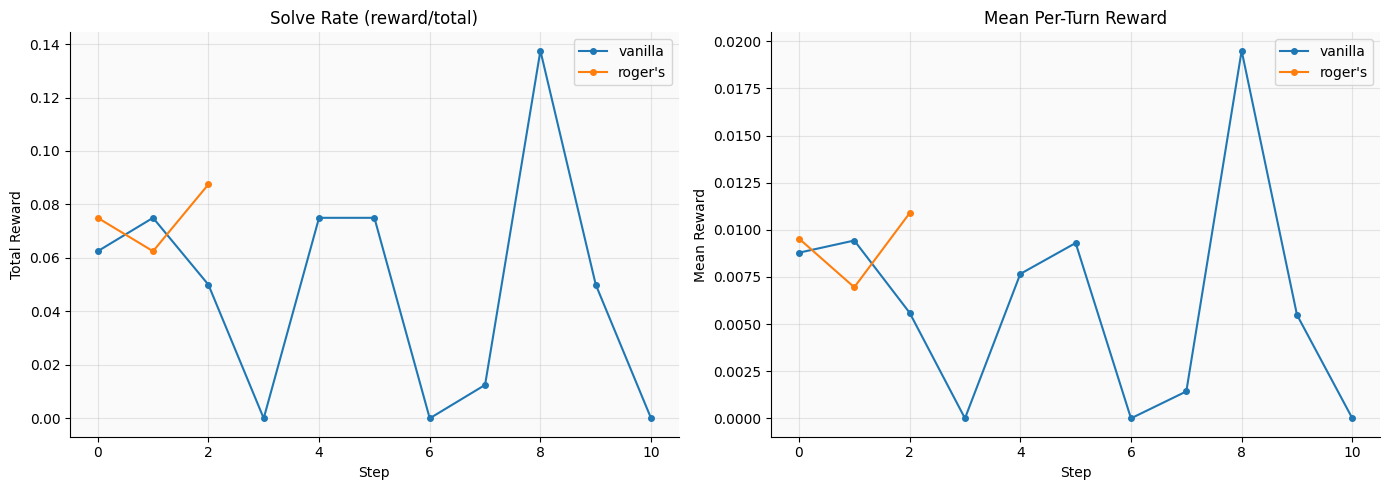

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total reward (solve rate proxy)
ax = axes[0]
for name, df in dfs.items():
    if "env/all/reward/total" in df.columns:
        ax.plot(df["step"], df["env/all/reward/total"], marker="o", markersize=4, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Total Reward")
ax.set_title("Solve Rate (reward/total)")
ax.legend()

# Mean per-turn reward
ax = axes[1]
for name, df in dfs.items():
    if "env/all/reward" in df.columns:
        ax.plot(df["step"], df["env/all/reward"], marker="o", markersize=4, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Mean Reward")
ax.set_title("Mean Per-Turn Reward")
ax.legend()

plt.tight_layout()
plt.show()

## KL Divergence & Entropy

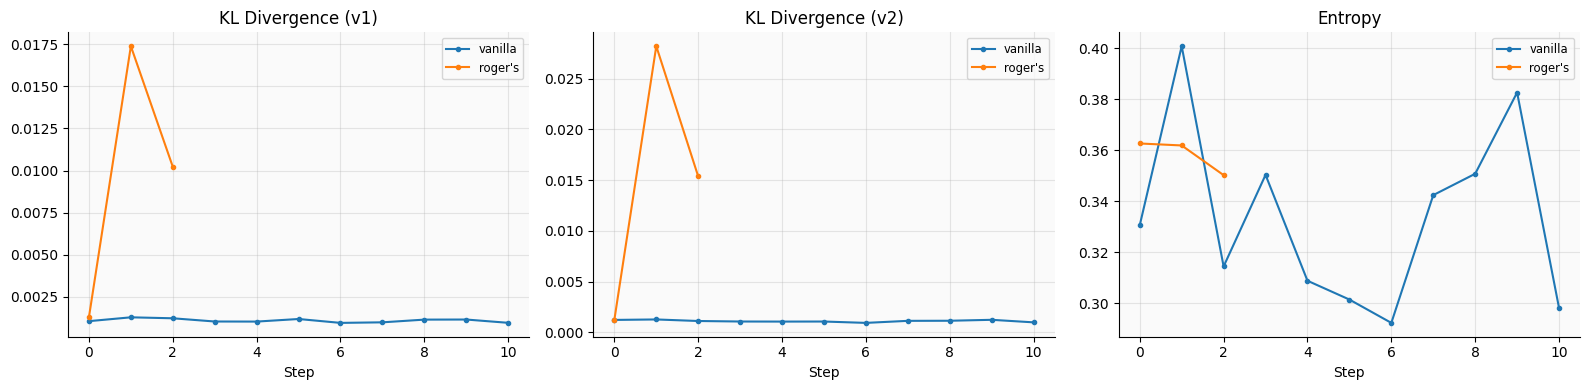

In [20]:
kl_entropy_cols = {
    "optim/kl_sample_train_v1": "KL Divergence (v1)",
    "optim/kl_sample_train_v2": "KL Divergence (v2)",
    "optim/entropy": "Entropy",
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, (col, title) in zip(axes, kl_entropy_cols.items()):
    for name, df in dfs.items():
        if col in df.columns:
            ax.plot(df["step"], df[col], marker="o", markersize=3, label=name)
    ax.set_xlabel("Step")
    ax.set_title(title)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

## Episode Statistics

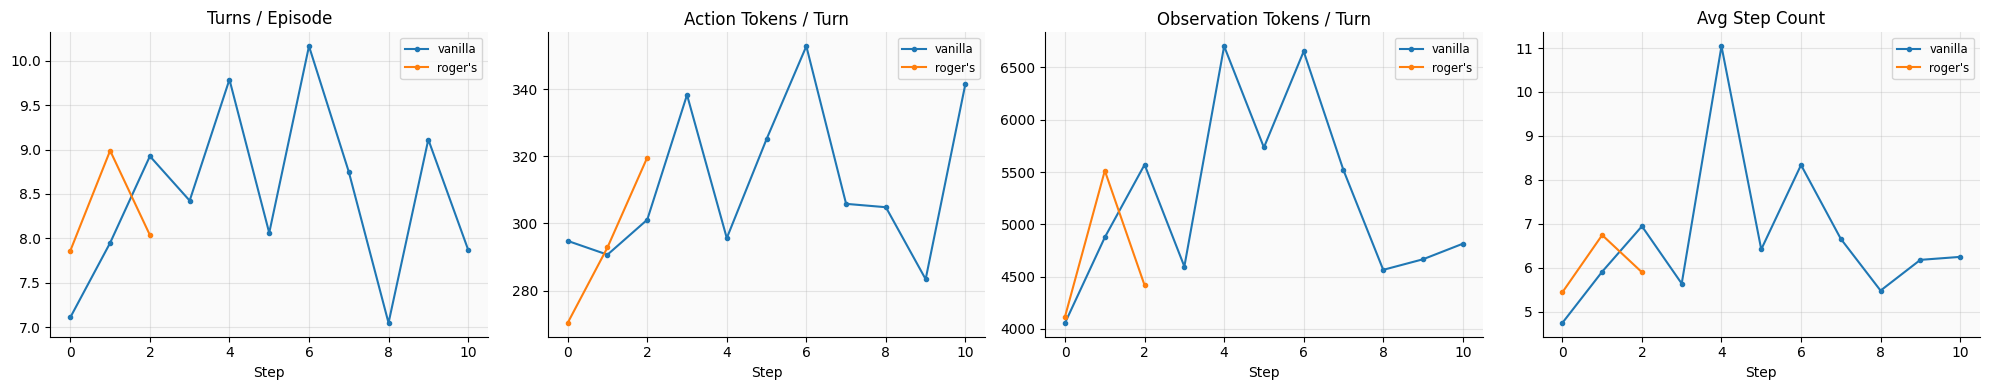

In [21]:
episode_cols = {
    "env/all/turns_per_episode": "Turns / Episode",
    "env/all/ac_tokens_per_turn": "Action Tokens / Turn",
    "env/all/ob_tokens_per_turn": "Observation Tokens / Turn",
    "env/all/step_count": "Avg Step Count",
}

available = {k: v for k, v in episode_cols.items() if any(k in df.columns for df in dfs.values())}
n = len(available)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
if n == 1:
    axes = [axes]

for ax, (col, title) in zip(axes, available.items()):
    for name, df in dfs.items():
        if col in df.columns:
            ax.plot(df["step"], df[col], marker="o", markersize=3, label=name)
    ax.set_xlabel("Step")
    ax.set_title(title)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

## Group Composition (Solve Rate Breakdown)

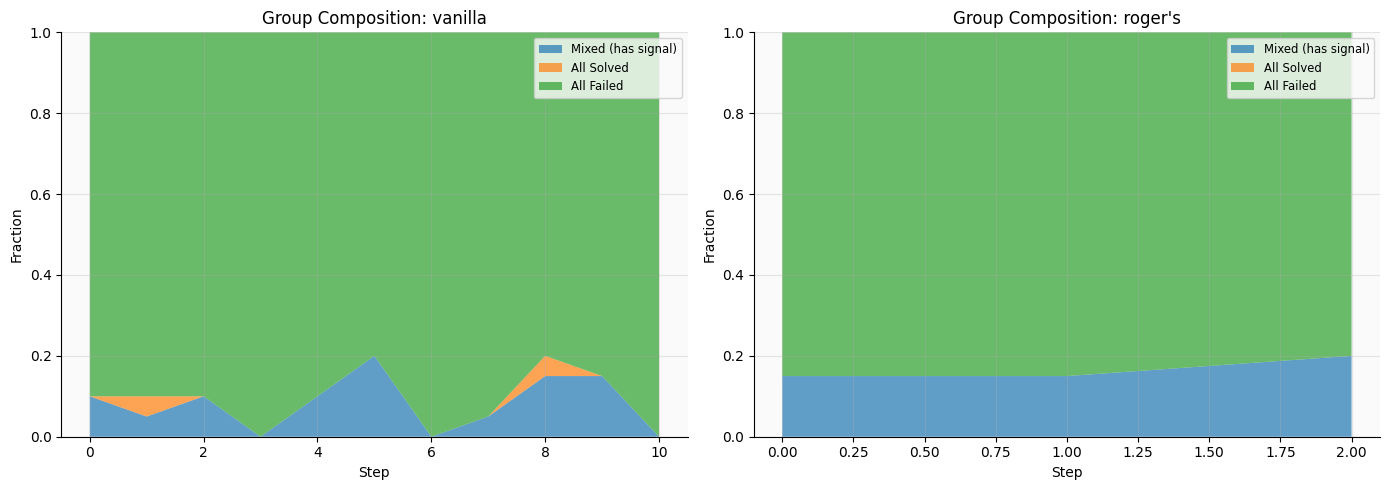

In [22]:
group_cols = {
    "env/all/by_group/frac_mixed": "Mixed (has signal)",
    "env/all/by_group/frac_all_good": "All Solved",
    "env/all/by_group/frac_all_bad": "All Failed",
}

n_runs = len(dfs)
fig, axes = plt.subplots(1, n_runs, figsize=(7 * n_runs, 5), squeeze=False)

for i, (name, df) in enumerate(dfs.items()):
    ax = axes[0, i]
    available = {k: v for k, v in group_cols.items() if k in df.columns}
    if available:
        ax.stackplot(
            df["step"],
            *[df[col] for col in available],
            labels=list(available.values()),
            alpha=0.7,
        )
        ax.set_ylim(0, 1)
    ax.set_xlabel("Step")
    ax.set_ylabel("Fraction")
    ax.set_title(f"Group Composition: {name}")
    ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()

## Timing Breakdown

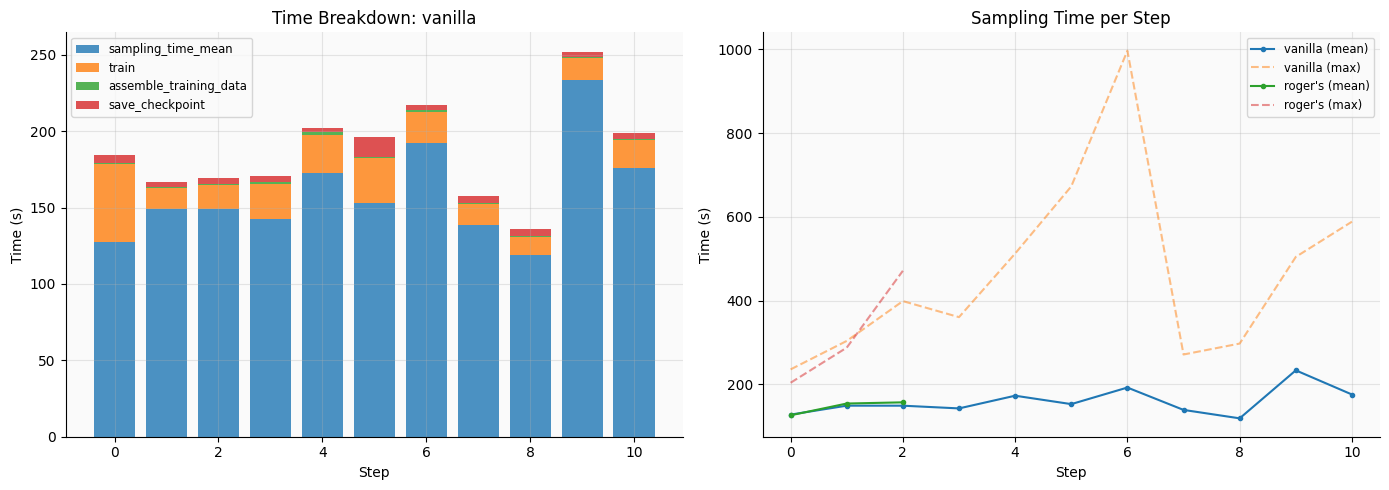

In [23]:
time_cols_of_interest = [
    "time/sampling_time_mean",
    "time/train",
    "time/training_loop/total",
    "time/assemble_training_data",
    "time/save_checkpoint",
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar: time breakdown per step (first run only as example)
ax = axes[0]
ref_name, ref_df = next(iter(dfs.items()))
bar_cols = [c for c in ["time/sampling_time_mean", "time/train", "time/assemble_training_data", "time/save_checkpoint"] if c in ref_df.columns]
bottom = None
for col in bar_cols:
    label = col.removeprefix("time/")
    vals = ref_df[col].fillna(0)
    ax.bar(ref_df["step"], vals, bottom=bottom, label=label, alpha=0.8)
    bottom = vals if bottom is None else bottom + vals
ax.set_xlabel("Step")
ax.set_ylabel("Time (s)")
ax.set_title(f"Time Breakdown: {ref_name}")
ax.legend(fontsize="small")

# Sampling time comparison across runs
ax = axes[1]
for name, df in dfs.items():
    if "time/sampling_time_mean" in df.columns:
        ax.plot(df["step"], df["time/sampling_time_mean"], marker="o", markersize=3, label=f"{name} (mean)")
    if "time/sampling_time_max" in df.columns:
        ax.plot(df["step"], df["time/sampling_time_max"], linestyle="--", alpha=0.5, label=f"{name} (max)")
ax.set_xlabel("Step")
ax.set_ylabel("Time (s)")
ax.set_title("Sampling Time per Step")
ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

## Off-Policy Staleness & Learning Rate

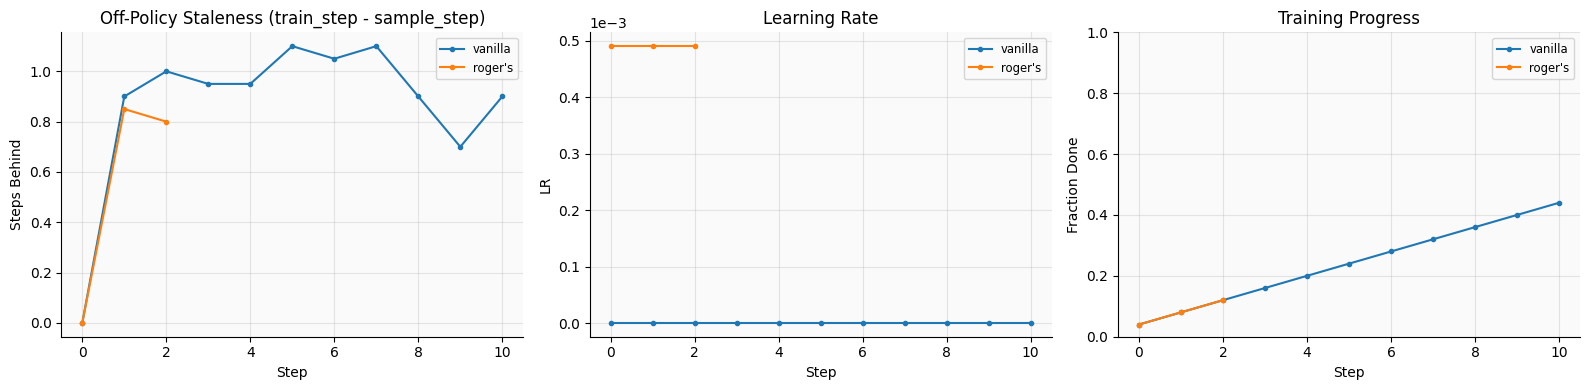

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Off-policy staleness (how far behind sampling is from training)
ax = axes[0]
for name, df in dfs.items():
    if "sampling_client/step_mean" in df.columns:
        staleness = df["step"] - df["sampling_client/step_mean"]
        ax.plot(df["step"], staleness, marker="o", markersize=3, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Steps Behind")
ax.set_title("Off-Policy Staleness (train_step - sample_step)")
ax.legend(fontsize="small")

# Learning rate schedule
ax = axes[1]
for name, df in dfs.items():
    if "optim/lr" in df.columns:
        ax.plot(df["step"], df["optim/lr"], marker="o", markersize=3, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("LR")
ax.set_title("Learning Rate")
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-3, -3))
ax.legend(fontsize="small")

# Progress
ax = axes[2]
for name, df in dfs.items():
    if "progress/done_frac" in df.columns:
        ax.plot(df["step"], df["progress/done_frac"], marker="o", markersize=3, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Fraction Done")
ax.set_title("Training Progress")
ax.set_ylim(0, 1)
ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

## Token Throughput & Cumulative Episodes

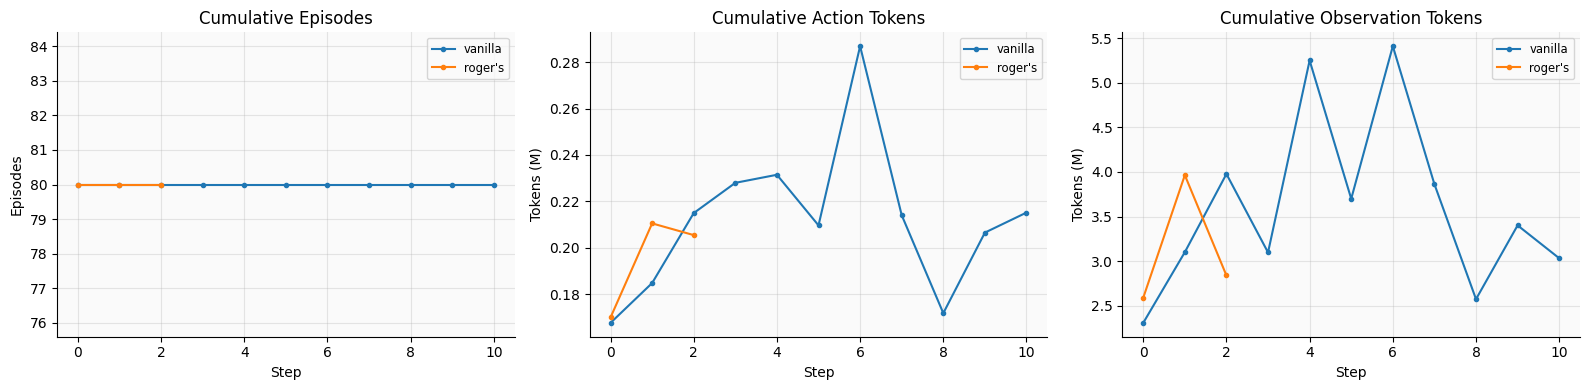

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Cumulative episodes
ax = axes[0]
for name, df in dfs.items():
    if "env/all/total_episodes" in df.columns:
        ax.plot(df["step"], df["env/all/total_episodes"], marker="o", markersize=3, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Episodes")
ax.set_title("Cumulative Episodes")
ax.legend(fontsize="small")

# Cumulative action tokens
ax = axes[1]
for name, df in dfs.items():
    if "env/all/total_ac_tokens" in df.columns:
        ax.plot(df["step"], df["env/all/total_ac_tokens"] / 1e6, marker="o", markersize=3, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Tokens (M)")
ax.set_title("Cumulative Action Tokens")
ax.legend(fontsize="small")

# Cumulative observation tokens
ax = axes[2]
for name, df in dfs.items():
    if "env/all/total_ob_tokens" in df.columns:
        ax.plot(df["step"], df["env/all/total_ob_tokens"] / 1e6, marker="o", markersize=3, label=name)
ax.set_xlabel("Step")
ax.set_ylabel("Tokens (M)")
ax.set_title("Cumulative Observation Tokens")
ax.legend(fontsize="small")

plt.tight_layout()
plt.show()